This notebook analyzes cases deemed medically qualified that went to the PRB for a vote from Jan. 1, 2022 to Jun. 16, 2023.

In [57]:
import pandas as pd
import re

In [302]:
# load source data copied down from google sheets

# load grants
grants = pd.read_csv('source/prb_mr_case_voting_tracker_grants_6.16.23.csv')

# load denials
den = pd.read_csv('source/prb_mr_case_voting_tracker_denials_6.16.23.csv')

In [303]:
grants.head()

,MR #,Last Name,First Name,IDOC #,Date granted,Vote,Members
0,MR0009,Bahrs,Shawn,B19308,4/18/2022,(3-0),"For: Crigler, Bohland Miller"
1,MR0105,Barnett,C A,Y20852,3/24/2023,(3-0),"For: Coates, Shelton, Shoffner"
2,MR0097,Belmore,Bryant,N12623,3/3/2023,(3-0),"For: Crigler, Globokar, Miller"
3,MR0071,Brookmyer,Rita,N97463,11/18/2022,(3-0),"For: Globokar, Shoffner, Tupy"
4,MR0047,Burke,Dewayne,N80531,7/29/2022,(3-0),"For: Crigler, Bohland, Shelton"


In [304]:
den.head()

,MR #,Last Name,First Name,IDOC #,Date denied,Vote,Members
0,MR0002,Burke,Dwayne,N80531,3/16/2022,(3-0),"For: Bohland, Miller, Tupy"
1,MR0013,Miller,Joseph,A82547,4/18/2022,(3-0),"For: Crigler, Bohland Miller"
2,MR0014,Perkins,Ernest,N82771,4/18/2022,(3-0),"For: Crigler, Bohland Miller"
3,MR0015,Wiggins,Malcolm,N04370,4/18/2022,(3-0),"For: Crigler, Bohland Miller"
4,MR0011,Rhoiney,Eugene,A15243,4/18/2022,(3-0),"For: Crigler, Bohland Miller"


## Create and clean a cases dataframe

In [305]:
# clean data types for grants and denials

# format members and votes as strings
grants['Members'] = grants['Members'].astype(str)
den['Members'] = den['Members'].astype(str)

In [306]:
# clean up and reformat Members col int members_for and members_against cols for grants and denials dfs separately 
# members_for = voted to grant release
# members_against = voted against granting release

# create functions to grab for and against members from the Members 
def get_members_for(row):
    split_list = re.split('Against', row[6])
    members_for = split_list[0].replace('For: ', '')
    return members_for

def get_members_against(row):
    split_list = re.split('Against', row[6])
    if len(split_list) == 2:
        return split_list[1]
    else:
        return ''

# apply these functions to cases in two new cols: members_for and members_against
# it's reversed for grants and den
grants['members_for'] = grants.apply(get_members_for, axis=1)
grants['members_against'] = grants.apply(get_members_against, axis=1)

den['members_for'] = den.apply(get_members_against, axis=1)
den['members_against'] = den.apply(get_members_for, axis=1)

In [307]:
# prep one combined cases df

# rename date cols
grants = grants.rename(columns={'Date granted': 'Date decided'})
den = den.rename(columns={'Date denied': 'Date decided'})

# add row for decision and append grants and denials
grants['decision'] = 'grant'
den['decision'] = 'denial'

cases = pd.concat([grants, den])

In [308]:
cases.tail()

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision
70,MR0128,Linzy,Joe,B03244,6/2/2023,(3-0),"For: Miller, Shoffner, Grubbs",,"Miller, Shoffner, Grubbs",denial
71,MR0123,Hughes,Stanley,A60835,6/16/2023,(3-0),"For: Bohland, Globokar, Terrones",,"Bohland, Globokar, Terrones",denial
72,MR0132,Green,Tyreed,A01806,6/16/2023,(3-0),"For: Bohland, Globokar, Terrones",,"Bohland, Globokar, Terrones",denial
73,MR0124,Barnwell,James,A15031,6/16/2023,(3-0),"For: Bohland, Globokar, Terrones",,"Bohland, Globokar, Terrones",denial
74,MR0129,Hrecko,Matthew,A76273,6/16/2023,(2-1),"For: Bohland Terrones, Against Globokar",Globokar,"Bohland Terrones,",denial


In [369]:
# clean data types

# convert date granted to datetime object
cases['Date decided'] = pd.to_datetime(cases['Date decided'])

# create a year col
cases['year'] = cases['Date decided'].dt.year

# create a month_year col
cases['month_year'] = cases['Date decided'].dt.strftime('%m/%Y')

# create a month col
cases['month'] = cases['Date decided'].dt.month

In [370]:
# get panel name col

# create a function to clean the string of members names
def clean(string):
    string = string.replace('.','')
    string = string.replace(':','')
    string = string.replace(',','')
    string = string.replace(';','')
    string = string.strip()
    return string

# apply the function to clean up members_for and members_against cols
cases['members_for'] = cases['members_for'].apply(clean)
cases['members_against'] = cases['members_against'].apply(clean)

# create a panel col
cases['panel'] = cases['members_for'].astype(str) + ' ' + cases['members_against'].astype(str)

# remove trailing and leading spaces
for index,row in cases.iterrows():
    row['panel'] = row['panel'].strip()

In [404]:
# clean panel name 

# create a list sorted alphabetically and remove empty spaces
def clean_panel_name(panel):
    name_list = panel.split(' ')
    if name_list[0] == '' or name_list[-1] == '': # get lists with empty elements
        name_list = list(filter(None, name_list)) # removes empty elements
        name_list = sorted(name_list) # alpha sort list elements
        return name_list
    else:
        return name_list
    
cases['panel_list'] = cases['panel'].apply(clean_panel_name)

# convert from list to string
def convert(lst):
     return " ".join(lst)

cases['panel_clean'] = cases['panel_list'].apply(convert)

In [405]:
cases

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision,year,month_year,month,panel,panel_clean,panel_list
0,MR0009,Bahrs,Shawn,B19308,2022-04-18,(3-0),"For: Crigler, Bohland Miller",Crigler Bohland Miller,,grant,2022,04/2022,4,Crigler Bohland Miller,Bohland Crigler Miller,"[Bohland, Crigler, Miller]"
1,MR0105,Barnett,C A,Y20852,2023-03-24,(3-0),"For: Coates, Shelton, Shoffner",Coates Shelton Shoffner,,grant,2023,03/2023,3,Coates Shelton Shoffner,Coates Shelton Shoffner,"[Coates, Shelton, Shoffner]"
2,MR0097,Belmore,Bryant,N12623,2023-03-03,(3-0),"For: Crigler, Globokar, Miller",Crigler Globokar Miller,,grant,2023,03/2023,3,Crigler Globokar Miller,Crigler Globokar Miller,"[Crigler, Globokar, Miller]"
3,MR0071,Brookmyer,Rita,N97463,2022-11-18,(3-0),"For: Globokar, Shoffner, Tupy",Globokar Shoffner Tupy,,grant,2022,11/2022,11,Globokar Shoffner Tupy,Globokar Shoffner Tupy,"[Globokar, Shoffner, Tupy]"
4,MR0047,Burke,Dewayne,N80531,2022-07-29,(3-0),"For: Crigler, Bohland, Shelton",Crigler Bohland Shelton,,grant,2022,07/2022,7,Crigler Bohland Shelton,Bohland Crigler Shelton,"[Bohland, Crigler, Shelton]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,MR0128,Linzy,Joe,B03244,2023-06-02,(3-0),"For: Miller, Shoffner, Grubbs",,Miller Shoffner Grubbs,denial,2023,06/2023,6,Miller Shoffner Grubbs,Grubbs Miller Shoffner,"[Grubbs, Miller, Shoffner]"
71,MR0123,Hughes,Stanley,A60835,2023-06-16,(3-0),"For: Bohland, Globokar, Terrones",,Bohland Globokar Terrones,denial,2023,06/2023,6,Bohland Globokar Terrones,Bohland Globokar Terrones,"[Bohland, Globokar, Terrones]"
72,MR0132,Green,Tyreed,A01806,2023-06-16,(3-0),"For: Bohland, Globokar, Terrones",,Bohland Globokar Terrones,denial,2023,06/2023,6,Bohland Globokar Terrones,Bohland Globokar Terrones,"[Bohland, Globokar, Terrones]"
73,MR0124,Barnwell,James,A15031,2023-06-16,(3-0),"For: Bohland, Globokar, Terrones",,Bohland Globokar Terrones,denial,2023,06/2023,6,Bohland Globokar Terrones,Bohland Globokar Terrones,"[Bohland, Globokar, Terrones]"


## Create and clean a PRB members dataframe

In [312]:
# import manually created master list of prb members: current and former and their affiliations
prb = pd.read_csv('manual/PRB Board Members Master List (Current and Former) - Master List_8.16.23.csv')

In [313]:
prb.head()

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County
0,"Bohland, Jared",Bohland,Jared,01/18/2027,05/03/2021,Republican,Governor,Member,Macon
1,"Coates, Matthew",Coates,Matthew,01/18/2027,07/01/2022,Democrat,Governor,Member,McLean
2,"Globokar, Julie",Globokar,Julie,01/20/2025,07/05/2022,Democrat,Governor,Member,Cook
3,"Goff, Darryldean",Goff,Darryldean,01/20/2025,05/15/2023,Democrat,Governor,Member,Lawrence
4,"Grubbs, Jeffrey",Grubbs,Jeffrey,01/20/2025,11/01/2022,Democrat,Governor,Member,Jackson


In [314]:
# create a new dataframe by member with yays and nays

# convert Last to string
prb['Last'] = prb['Last'].astype(str)

# functions to parse cases df and look up the number of instances each member shows up in the members_for and members_against cols
def get_yays(member):
    yays = cases['members_for'].str.count(member)
    return yays.sum()

def get_nays(member):
    nays = cases['members_against'].str.count(member)
    return nays.sum()

prb['yays'] = prb['Last'].apply(get_yays)
prb['nays'] = prb['Last'].apply(get_nays)

In [324]:
# add total cases and pct yays and nays
prb['total cases'] = prb['yays'] + prb['nays']
prb['pct yays'] = prb['yays']/prb['total cases']
prb['pct nays'] = prb['nays']/prb['total cases']

In [325]:
prb

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,yays,nays,total cases,pct yays,pct nays
0,"Bohland, Jared",Bohland,Jared,01/18/2027,05/03/2021,Republican,Governor,Member,Macon,8,44,52,0.153846,0.846154
1,"Coates, Matthew",Coates,Matthew,01/18/2027,07/01/2022,Democrat,Governor,Member,McLean,8,8,16,0.500000,0.500000
2,"Globokar, Julie",Globokar,Julie,01/20/2025,07/05/2022,Democrat,Governor,Member,Cook,12,13,25,0.480000,0.520000
3,"Goff, Darryldean",Goff,Darryldean,01/20/2025,05/15/2023,Democrat,Governor,Member,Lawrence,0,0,0,NaN,NaN
4,"Grubbs, Jeffrey",Grubbs,Jeffrey,01/20/2025,11/01/2022,Democrat,Governor,Member,Jackson,3,10,13,0.230769,0.769231
5,"Heaton, Rodger",Heaton,Rodger,01/20/2025,05/01/2022,Republican,Governor,Member,Cook,9,12,21,0.428571,0.571429
6,"Miller, Lee Ann",Miller,Lee Ann,01/18/2027,09/02/2021,Republican,Governor,Member,Gallatin,17,39,56,0.303571,0.696429
7,"Shelton, Donald",Shelton,Donald,01/15/2029,09/20/2012,Republican,Governor,Chair,Sangamon,15,22,37,0.405405,0.594595
8,"Shoffner, Robin",Shoffner,Robin,01/18/2027,05/01/2022,Democrat,Governor,Member,Cook,13,14,27,0.481481,0.518519
9,"Terrones, Carmen",Terrones,Carmen,01/20/2025,06/27/2022,Democrat,Governor,Member,Cook,11,16,27,0.407407,0.592593


## Approvals/denials by month and year

In [289]:
# pivot by month_year and decision outcome
cases_by_month = pd.pivot_table(cases, values='MR #', index='month_year', columns='decision', aggfunc='count').reset_index()

In [290]:
# fill NaN with 0
cases_by_month = cases_by_month.fillna(0)

In [291]:
# clean up pivoted data

# fill NaN with 0
cases_by_month = cases_by_month.fillna(0)

# format as date
cases_by_month['month_year'] = pd.to_datetime(cases_by_month['month_year'])

# reformat as mm/yyy
# cases_by_month['month_year'] = cases_by_month['month_year'].dt.strftime('%m/%Y')

In [292]:
# check denial count is 75
cases_by_month['denial'].sum()

75.0

In [293]:
# check grant count is 46
cases_by_month['grant'].sum()

46.0

In [294]:
# copied this into findings doc
cases_by_month.sort_values('month_year', ascending=True)

decision,month_year,denial,grant
1,2022-02-01,0.0,2.0
3,2022-03-01,1.0,3.0
5,2022-04-01,11.0,1.0
7,2022-05-01,8.0,2.0
9,2022-06-01,6.0,1.0
11,2022-07-01,6.0,4.0
12,2022-08-01,0.0,2.0
13,2022-09-01,3.0,5.0
14,2022-10-01,6.0,3.0
15,2022-11-01,4.0,2.0


## Panel frequency and outcomes

In [409]:
cases.to_csv('test.csv')

In [406]:
# count the number of times the panel 
panel_freq = cases.groupby('panel_clean').size().reset_index(name='count').sort_values('count', ascending=False)
panel_freq['pct'] = panel_freq['count']/panel_freq['count'].sum()

# top 5 more frequent panels
panel_freq.head(5)

,panel_clean,count,pct
1,Bohland Crigler Miller,9,0.074380
7,Bohland Miller Tupy,6,0.049587
35,Globokar Shoffner Tupy,6,0.049587
18,Crigler Globokar Miller,5,0.041322
38,Grubbs Miller Shoffner,5,0.041322


In [413]:
# pivot by panel and grant 
panel_pivot = pd.pivot_table(cases, values='MR #', index='panel_clean', columns='decision', aggfunc='count').reset_index()
panel_pivot = panel_pivot.fillna(0)
panel_pivot['total cases'] = panel_pivot['denial'] + panel_pivot['grant']
panel_pivot['pct cases denied'] = panel_pivot['denial']/panel_pivot['total cases']
panel_pivot.sort_values('total cases', ascending=False)

decision,panel_clean,denial,grant,total cases,pct cases denied
1,Bohland Crigler Miller,7.0,2.0,9.0,0.777778
7,Bohland Miller Tupy,6.0,0.0,6.0,1.000000
35,Globokar Shoffner Tupy,3.0,3.0,6.0,0.500000
18,Crigler Globokar Miller,3.0,2.0,5.0,0.600000
38,Grubbs Miller Shoffner,3.0,2.0,5.0,0.600000
14,Coates Shelton Shoffner,1.0,3.0,4.0,0.250000
2,Bohland Crigler Shelton,3.0,1.0,4.0,0.750000
3,Bohland Globokar Terrones,3.0,1.0,4.0,0.750000
4,Bohland Grubbs Terrones,4.0,0.0,4.0,1.000000
6,Bohland Miller Shelton,3.0,1.0,4.0,0.750000


In [418]:
# most leniant panel
panel_pivot.sort_values('grant', ascending=False).head()

decision,panel_clean,denial,grant,total cases,pct cases denied
14,Coates Shelton Shoffner,1.0,3.0,4.0,0.250000
35,Globokar Shoffner Tupy,3.0,3.0,6.0,0.500000
18,Crigler Globokar Miller,3.0,2.0,5.0,0.600000
30,Daniels Heaton Miller Terrones,0.0,2.0,2.0,0.000000
1,Bohland Crigler Miller,7.0,2.0,9.0,0.777778


In [420]:
# was coates shelton shoffner unanimous? yes
cases[cases['panel_clean'] == 'Coates Shelton Shoffner']

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision,year,month_year,month,panel,panel_clean,panel_list
1,MR0105,Barnett,C A,Y20852,2023-03-24,(3-0),"For: Coates, Shelton, Shoffner",Coates Shelton Shoffner,,grant,2023,03/2023,3,Coates Shelton Shoffner,Coates Shelton Shoffner,"[Coates, Shelton, Shoffner]"
5,MR0104,Burns,Richard,R31862,2023-03-24,(3-0),"For: Coates, Shelton, Shoffner",Coates Shelton Shoffner,,grant,2023,03/2023,3,Coates Shelton Shoffner,Coates Shelton Shoffner,"[Coates, Shelton, Shoffner]"
17,MR0106,Ford,James,B43562,2023-03-24,(3-0),"For: Coates, Shelton, Shoffner",Coates Shelton Shoffner,,grant,2023,03/2023,3,Coates Shelton Shoffner,Coates Shelton Shoffner,"[Coates, Shelton, Shoffner]"
61,MR0103,Bassett,Gino,K55476,2023-03-24,(3-0),"For: Coates, Shelton, Shoffner",,Coates Shelton Shoffner,denial,2023,03/2023,3,Coates Shelton Shoffner,Coates Shelton Shoffner,"[Coates, Shelton, Shoffner]"


In [419]:
# most denied panel
panel_pivot.sort_values('denial', ascending=False).head()

decision,panel_clean,denial,grant,total cases,pct cases denied
1,Bohland Crigler Miller,7.0,2.0,9.0,0.777778
7,Bohland Miller Tupy,6.0,0.0,6.0,1.000000
4,Bohland Grubbs Terrones,4.0,0.0,4.0,1.000000
45,Miller Shoffner Tupy and,4.0,0.0,4.0,1.000000
35,Globokar Shoffner Tupy,3.0,3.0,6.0,0.500000


## Share of votes for each board member

In [326]:
# create an analysis copy of prb 
prb_analysis = prb.copy()

In [327]:
# calculate percent of all cases each board member voted in
prb_analysis['pct share of cases'] = prb_analysis['total cases']/len(cases)
prb_analysis.sort_values('pct share of cases', ascending=False)

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,yays,nays,total cases,pct yays,pct nays,pct share of cases
6,"Miller, Lee Ann",Miller,Lee Ann,01/18/2027,09/02/2021,Republican,Governor,Member,Gallatin,17,39,56,0.303571,0.696429,0.462810
0,"Bohland, Jared",Bohland,Jared,01/18/2027,05/03/2021,Republican,Governor,Member,Macon,8,44,52,0.153846,0.846154,0.429752
15,Edith Crigler,Crigler,Edith,Former,03/28/2017,NaN,NaN,NaN,NaN,24,16,40,0.600000,0.400000,0.330579
7,"Shelton, Donald",Shelton,Donald,01/15/2029,09/20/2012,Republican,Governor,Chair,Sangamon,15,22,37,0.405405,0.594595,0.305785
11,"Tupy, Kenneth",Tupy,Kenneth,01/15/2029,05/03/2021,Republican,Governor,Member,Sangamon,6,30,36,0.166667,0.833333,0.297521
8,"Shoffner, Robin",Shoffner,Robin,01/18/2027,05/01/2022,Democrat,Governor,Member,Cook,13,14,27,0.481481,0.518519,0.223140
9,"Terrones, Carmen",Terrones,Carmen,01/20/2025,06/27/2022,Democrat,Governor,Member,Cook,11,16,27,0.407407,0.592593,0.223140
2,"Globokar, Julie",Globokar,Julie,01/20/2025,07/05/2022,Democrat,Governor,Member,Cook,12,13,25,0.480000,0.520000,0.206612
5,"Heaton, Rodger",Heaton,Rodger,01/20/2025,05/01/2022,Republican,Governor,Member,Cook,9,12,21,0.428571,0.571429,0.173554
1,"Coates, Matthew",Coates,Matthew,01/18/2027,07/01/2022,Democrat,Governor,Member,McLean,8,8,16,0.500000,0.500000,0.132231


## How many cases ended up approved/denied as measured by which members were on the panel

In [423]:
# how many cases were approved/denied when boland was on the panel?
cases[cases['panel_clean'].str.contains('Bohland')].groupby('decision').size()

decision
denial    36
grant     16
dtype: int64

In [425]:
# bohland voted against the grant in 8 out of 16
cases[(cases['panel_clean'].str.contains('Bohland')) & (cases['decision'] == 'grant')]

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision,year,month_year,month,panel,panel_clean,panel_list
0,MR0009,Bahrs,Shawn,B19308,2022-04-18,(3-0),"For: Crigler, Bohland Miller",Crigler Bohland Miller,,grant,2022,04/2022,4,Crigler Bohland Miller,Bohland Crigler Miller,"[Bohland, Crigler, Miller]"
4,MR0047,Burke,Dewayne,N80531,2022-07-29,(3-0),"For: Crigler, Bohland, Shelton",Crigler Bohland Shelton,,grant,2022,07/2022,7,Crigler Bohland Shelton,Bohland Crigler Shelton,"[Bohland, Crigler, Shelton]"
8,MR0086,Cody,Lawrence,K039605,2023-01-20,(2-1),"For: Heaton, Shoffner. Against: Bohland",Heaton Shoffner,Bohland,grant,2023,01/2023,1,Heaton Shoffner Bohland,Heaton Shoffner Bohland,"[Heaton, Shoffner, Bohland]"
9,MR0126,Colbert,Saul,A15110,2023-06-16,(2-1),"For: Globokar, Terrones Against Bohland",Globokar Terrones,Bohland,grant,2023,06/2023,6,Globokar Terrones Bohland,Globokar Terrones Bohland,"[Globokar, Terrones, Bohland]"
21,MR0033,Henry,Jessie,K63626,2022-05-27,(3-0),"For: Bohland, Miller, Shelton",Bohland Miller Shelton,,grant,2022,05/2022,5,Bohland Miller Shelton,Bohland Miller Shelton,"[Bohland, Miller, Shelton]"
22,MR0075,Horton,William,B54737,2022-12-02,(3-0),"For: Bohland, Crigler, Heaton",Bohland Crigler Heaton,,grant,2022,12/2022,12,Bohland Crigler Heaton,Bohland Crigler Heaton,"[Bohland, Crigler, Heaton]"
25,MR0044,Jones,Robert,A01990,2022-07-29,(2-1),"For: Crigler, Shelton. Against: Bohland",Crigler Shelton,Bohland,grant,2022,07/2022,7,Crigler Shelton Bohland,Crigler Shelton Bohland,"[Crigler, Shelton, Bohland]"
26,MR0127,Jones,William,Y36585,2023-06-16,(3-0),"For: Bohland, Globokar, Terrones",Bohland Globokar Terrones,,grant,2023,06/2023,6,Bohland Globokar Terrones,Bohland Globokar Terrones,"[Bohland, Globokar, Terrones]"
27,MR0005,Long,Gregory,R14003,2022-03-04,(3-0),"For: Crigler, Miller, Bohland",Crigler Miller Bohland,,grant,2022,03/2022,3,Crigler Miller Bohland,Bohland Crigler Miller,"[Bohland, Crigler, Miller]"
29,MR0048,McAfee,Maulton,B04099,2022-07-29,(2-1),"For: Crigler, Shelton. Against: Bohland",Crigler Shelton,Bohland,grant,2022,07/2022,7,Crigler Shelton Bohland,Crigler Shelton Bohland,"[Crigler, Shelton, Bohland]"


In [426]:
cases[(cases['panel_clean'].str.contains('Bohland')) & (cases['decision'] == 'denial')]

,MR #,Last Name,First Name,IDOC #,Date decided,Vote,Members,members_for,members_against,decision,year,month_year,month,panel,panel_clean,panel_list
0,MR0002,Burke,Dwayne,N80531,2022-03-16,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,03/2022,3,Bohland Miller Tupy,Bohland Miller Tupy,"[Bohland, Miller, Tupy]"
1,MR0013,Miller,Joseph,A82547,2022-04-18,(3-0),"For: Crigler, Bohland Miller",,Crigler Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,Bohland Crigler Miller,"[Bohland, Crigler, Miller]"
2,MR0014,Perkins,Ernest,N82771,2022-04-18,(3-0),"For: Crigler, Bohland Miller",,Crigler Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,Bohland Crigler Miller,"[Bohland, Crigler, Miller]"
3,MR0015,Wiggins,Malcolm,N04370,2022-04-18,(3-0),"For: Crigler, Bohland Miller",,Crigler Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,Bohland Crigler Miller,"[Bohland, Crigler, Miller]"
4,MR0011,Rhoiney,Eugene,A15243,2022-04-18,(3-0),"For: Crigler, Bohland Miller",,Crigler Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,Bohland Crigler Miller,"[Bohland, Crigler, Miller]"
5,MR0012,Strowder,Jenette,R85449,2022-04-18,(2-1),"For: Bohland, Miller. Against: Crigler",Crigler,Bohland Miller,denial,2022,04/2022,4,Crigler Bohland Miller,Crigler Bohland Miller,"[Crigler, Bohland, Miller]"
6,MR0010,Moss,Carl,B18364,2022-04-29,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,04/2022,4,Bohland Miller Tupy,Bohland Miller Tupy,"[Bohland, Miller, Tupy]"
7,MR0016,Gill,Robert,R46711,2022-04-29,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,04/2022,4,Bohland Miller Tupy,Bohland Miller Tupy,"[Bohland, Miller, Tupy]"
8,MR0017,Muston,Billy,B63287,2022-04-29,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,04/2022,4,Bohland Miller Tupy,Bohland Miller Tupy,"[Bohland, Miller, Tupy]"
9,MR0018,Mohr,Scott,B44299,2022-04-29,(3-0),"For: Bohland, Miller, Tupy",,Bohland Miller Tupy,denial,2022,04/2022,4,Bohland Miller Tupy,Bohland Miller Tupy,"[Bohland, Miller, Tupy]"


## Relationship between length of time on board and participation

In [347]:
# is it because of when members were appointed?
prb_analysis['Member Since'] = pd.to_datetime(prb_analysis['Member Since'])

# only look at members with full start and expiration dates for now (As of Aug 17)
prb_date = prb_analysis[(prb_analysis['Member Since'].notnull()) & (prb_analysis['Member Expiration'] != 'Former')].copy()
# convert expiration and since to dates
prb_date['Member Since'] = pd.to_datetime(prb_date['Member Since'])
prb_date['Member Expiration'] = pd.to_datetime(prb_date['Member Expiration'])

# get time elapsed as of June 16, 2023
prb_date['data as of'] = '06/16/2023'
prb_date['data as of'] = pd.to_datetime(prb_date['data as of'])

prb_date['time on board'] = prb_date['data as of'] - prb_date['Member Since']

In [356]:
prb_date['time on board numerical'] = prb_date['time on board'].dt.days

In [359]:
prb_date.sort_values('time on board', ascending=False)

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,yays,nays,total cases,pct yays,pct nays,pct share of cases,data as of,time on board,time on board numerical
7,"Shelton, Donald",Shelton,Donald,2029-01-15,2012-09-20,Republican,Governor,Chair,Sangamon,15,22,37,0.405405,0.594595,0.305785,2023-06-16,3921 days,3921
0,"Bohland, Jared",Bohland,Jared,2027-01-18,2021-05-03,Republican,Governor,Member,Macon,8,44,52,0.153846,0.846154,0.429752,2023-06-16,774 days,774
11,"Tupy, Kenneth",Tupy,Kenneth,2029-01-15,2021-05-03,Republican,Governor,Member,Sangamon,6,30,36,0.166667,0.833333,0.297521,2023-06-16,774 days,774
6,"Miller, Lee Ann",Miller,Lee Ann,2027-01-18,2021-09-02,Republican,Governor,Member,Gallatin,17,39,56,0.303571,0.696429,0.462810,2023-06-16,652 days,652
5,"Heaton, Rodger",Heaton,Rodger,2025-01-20,2022-05-01,Republican,Governor,Member,Cook,9,12,21,0.428571,0.571429,0.173554,2023-06-16,411 days,411
8,"Shoffner, Robin",Shoffner,Robin,2027-01-18,2022-05-01,Democrat,Governor,Member,Cook,13,14,27,0.481481,0.518519,0.223140,2023-06-16,411 days,411
9,"Terrones, Carmen",Terrones,Carmen,2025-01-20,2022-06-27,Democrat,Governor,Member,Cook,11,16,27,0.407407,0.592593,0.223140,2023-06-16,354 days,354
1,"Coates, Matthew",Coates,Matthew,2027-01-18,2022-07-01,Democrat,Governor,Member,McLean,8,8,16,0.500000,0.500000,0.132231,2023-06-16,350 days,350
2,"Globokar, Julie",Globokar,Julie,2025-01-20,2022-07-05,Democrat,Governor,Member,Cook,12,13,25,0.480000,0.520000,0.206612,2023-06-16,346 days,346
4,"Grubbs, Jeffrey",Grubbs,Jeffrey,2025-01-20,2022-11-01,Democrat,Governor,Member,Jackson,3,10,13,0.230769,0.769231,0.107438,2023-06-16,227 days,227


<AxesSubplot:xlabel='time on board numerical', ylabel='pct share of cases'>

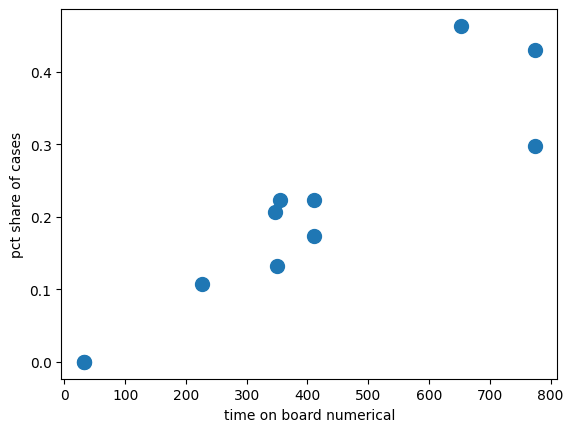

In [360]:
# exclude shelton as an outlier
prb_date[prb_date['Last'] != 'Shelton'].plot.scatter(x = 'time on board numerical', y = 'pct share of cases', s = 100)

## Relationship between voting patterns and participation 

In [328]:
prb_analysis.sort_values('pct nays', ascending=False).head()

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,yays,nays,total cases,pct yays,pct nays,pct share of cases
0,"Bohland, Jared",Bohland,Jared,01/18/2027,05/03/2021,Republican,Governor,Member,Macon,8,44,52,0.153846,0.846154,0.429752
11,"Tupy, Kenneth",Tupy,Kenneth,01/15/2029,05/03/2021,Republican,Governor,Member,Sangamon,6,30,36,0.166667,0.833333,0.297521
4,"Grubbs, Jeffrey",Grubbs,Jeffrey,01/20/2025,11/01/2022,Democrat,Governor,Member,Jackson,3,10,13,0.230769,0.769231,0.107438
6,"Miller, Lee Ann",Miller,Lee Ann,01/18/2027,09/02/2021,Republican,Governor,Member,Gallatin,17,39,56,0.303571,0.696429,0.462810
7,"Shelton, Donald",Shelton,Donald,01/15/2029,09/20/2012,Republican,Governor,Chair,Sangamon,15,22,37,0.405405,0.594595,0.305785


In [329]:
print(prb_analysis['pct nays'].corr(prb_analysis['pct share of cases']))

0.6098051230883359


In [330]:
print(prb_analysis['pct yays'].corr(prb_analysis['pct share of cases']))

-0.6098051230883358


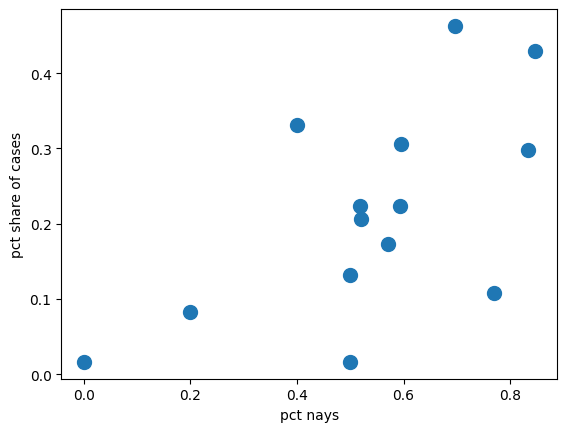

In [331]:
prb_analysis.plot.scatter(x = 'pct nays', y = 'pct share of cases', s = 100);

## Relationship between voting and party affiliation

In [334]:
# missing party affliation for 4 voting members (as of Aug. 17)
party = prb_analysis.groupby('Affiliation')[['yays','nays']].sum()
party['pct yays'] = party['yays']/(party['yays'] + party['nays'])
party['pct nays'] = party['nays']/(party['yays'] + party['nays'])
party

,yays,nays,pct yays,pct nays
Affiliation,,,,
Democrat,47,61,0.435185,0.564815
Independent,0,0,NaN,NaN
Republican,55,147,0.272277,0.727723


In [361]:
# board is split about half and half
prb_analysis.groupby('Affiliation').size()

Affiliation
Democrat       6
Independent    1
Republican     5
dtype: int64

In [363]:
# republicans accounted for 65 percent of all the denial votes but just 40 percent of grant votes
prb_analysis[prb_analysis['Affiliation'] == 'Republican']['nays'].sum()

147

In [364]:
prb_analysis['nays'].sum()

227

In [365]:
147/227

0.6475770925110133

In [366]:
prb_analysis[prb_analysis['Affiliation'] == 'Republican']['yays'].sum()

55

In [367]:
prb_analysis['yays'].sum()

137

In [368]:
55/137

0.40145985401459855

In [362]:
prb_analysis

,Name,Last,First,Member Expiration,Member Since,Affiliation,Appointed By,Position,County,yays,nays,total cases,pct yays,pct nays,pct share of cases
0,"Bohland, Jared",Bohland,Jared,01/18/2027,2021-05-03,Republican,Governor,Member,Macon,8,44,52,0.153846,0.846154,0.429752
1,"Coates, Matthew",Coates,Matthew,01/18/2027,2022-07-01,Democrat,Governor,Member,McLean,8,8,16,0.500000,0.500000,0.132231
2,"Globokar, Julie",Globokar,Julie,01/20/2025,2022-07-05,Democrat,Governor,Member,Cook,12,13,25,0.480000,0.520000,0.206612
3,"Goff, Darryldean",Goff,Darryldean,01/20/2025,2023-05-15,Democrat,Governor,Member,Lawrence,0,0,0,NaN,NaN,0.000000
4,"Grubbs, Jeffrey",Grubbs,Jeffrey,01/20/2025,2022-11-01,Democrat,Governor,Member,Jackson,3,10,13,0.230769,0.769231,0.107438
5,"Heaton, Rodger",Heaton,Rodger,01/20/2025,2022-05-01,Republican,Governor,Member,Cook,9,12,21,0.428571,0.571429,0.173554
6,"Miller, Lee Ann",Miller,Lee Ann,01/18/2027,2021-09-02,Republican,Governor,Member,Gallatin,17,39,56,0.303571,0.696429,0.462810
7,"Shelton, Donald",Shelton,Donald,01/15/2029,2012-09-20,Republican,Governor,Chair,Sangamon,15,22,37,0.405405,0.594595,0.305785
8,"Shoffner, Robin",Shoffner,Robin,01/18/2027,2022-05-01,Democrat,Governor,Member,Cook,13,14,27,0.481481,0.518519,0.223140
9,"Terrones, Carmen",Terrones,Carmen,01/20/2025,2022-06-27,Democrat,Governor,Member,Cook,11,16,27,0.407407,0.592593,0.223140
